# Практическое задание 2. Диффузионные модели


## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного жёсткого срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи !!ВАЖНО!!!
Задания сдаются через систему google classroom. Посылка должна содержать:
* Ноутбук ddpm_hw_bmmo-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## В этом задании необходимо будет дореализовать ключевые формулы для обучения дискретной [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
Для выполнения домашнего задания достаточно использовать Google Colab.


In [1]:
!python3 -V
import torch


print(f'torch.__version__: {torch.__version__}')

Python 3.10.12
torch.__version__: 2.5.0+cu121


In [2]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.4 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import random

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

## Dataset

In [4]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [5]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [6]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
    assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)

check_generator(131)

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-6-7f45e619ebd8>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
<ipython-input-6-7f45e619ebd8>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## DDPM's dynamic, 5 pts



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут вам рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


In [7]:
from torch import nn

def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)
    one_m_alphas_hat = 1 - alphas_hat

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])

    # YOUR CODE GOES HERE

    sqrt_alphas_hat = torch.sqrt(alphas_hat)
    sqrt_alphas_hat_prev = torch.sqrt(alphas_hat_prev)
    sqrt_1m_alphas_hat = torch.sqrt(one_m_alphas_hat)

    # q(x_t|x_(t+1), x_0) = normal(...)

    mu_hat_x_0 = (betas * sqrt_alphas_hat_prev) / (one_m_alphas_hat)
    mu_hat_x_t = ((1 - alphas_hat_prev) * sqrt_alphas) / (one_m_alphas_hat)

    betas_hat = (1 - alphas_hat_prev) / (one_m_alphas_hat) * betas
    sqrt_betas_hat = torch.sqrt(betas_hat)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_hat": alphas_hat,
        "alphas_hat_prev": alphas_hat_prev,
        "mu_hat_x_0": mu_hat_x_0,
        "mu_hat_x_t": mu_hat_x_t,
        "betas_hat": betas_hat,
        "sqrt_betas_hat": sqrt_betas_hat,
        "sqrt_alphas": sqrt_alphas,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_alphas_hat_prev": sqrt_alphas_hat_prev,
        "sqrt_1m_alphas_hat": sqrt_1m_alphas_hat,
        "one_m_alphas_hat": one_m_alphas_hat
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

In [8]:
from torch.distributions import multivariate_normal

class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:

        mu_hat_x_0 = extract_values_from_times(self.mu_hat_x_0, t)
        mu_hat_x_t = extract_values_from_times(self.mu_hat_x_t, t)
        betas_hat = extract_values_from_times(self.betas_hat, t)

        return torch.normal(mu_hat_x_0 * x_0 + mu_hat_x_t * x_t,\
                            betas_hat * torch.eye(x_t.shape[3]))

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch['x_0']
        t = batch['time']

        # YOUR CODE GOES HERE
        if 'eps' not in batch.keys():
          eps = torch.randn(x_0.shape, device=device)
        else:
          eps = batch['eps']

        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_t = sqrt_alphas_hat * x_0 + sqrt_1m_alphas_hat * eps
        return {
            "x_t": x_t,
            "eps": eps,
        }


In [9]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

### `Sampler`/DDPM's cycle: (1.5 pts)
- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

In [10]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        classes = None
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(self, x_t, t, classes=None, guidance_strength=0.5):

        if guidance_strength is None:
            guidance_strength = 0.5

        if t.sum() > 1:
          z = torch.randn(x_t.shape, device=device)
        else:
          z = torch.zeros(x_t.shape, device=device)

        # unconditional part
        eps_unconditional = self.ddpm(x_t, t,
                        classes=torch.zeros(x_t.shape[0], dtype=torch.int, device=device),
                        cond_drop_prob=1)

        # conditional part
        cond_drop_prob = 0

        if classes is None:
            classes = torch.zeros(x_t.shape[0], dtype=torch.int, device=device)
            cond_drop_prob = 1

        eps_conditional = self.ddpm(x_t, t,
                classes=classes,
                cond_drop_prob=cond_drop_prob)

        # eps_hat
        eps_hat = eps_unconditional * (1 - guidance_strength) + \
                  eps_conditional * (guidance_strength)

        sqrt_alphas = extract_values_from_times(self.dynamic.sqrt_alphas, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.dynamic.sqrt_1m_alphas_hat, t)
        sqrt_betas_hat = extract_values_from_times(self.dynamic.sqrt_betas_hat, t)
        betas = extract_values_from_times(self.dynamic.betas, t)

        mu_theta = 1 / sqrt_alphas * (x_t - (betas / sqrt_1m_alphas_hat) * eps_hat)
        return mu_theta.to(device) + z.to(device) * sqrt_betas_hat.to(device)


    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False,
        classes = None,
        guidance_strength = None
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor, classes, guidance_strength)
        return x_t


###При помощи примитивов сверху реализовать обучение ddpm.


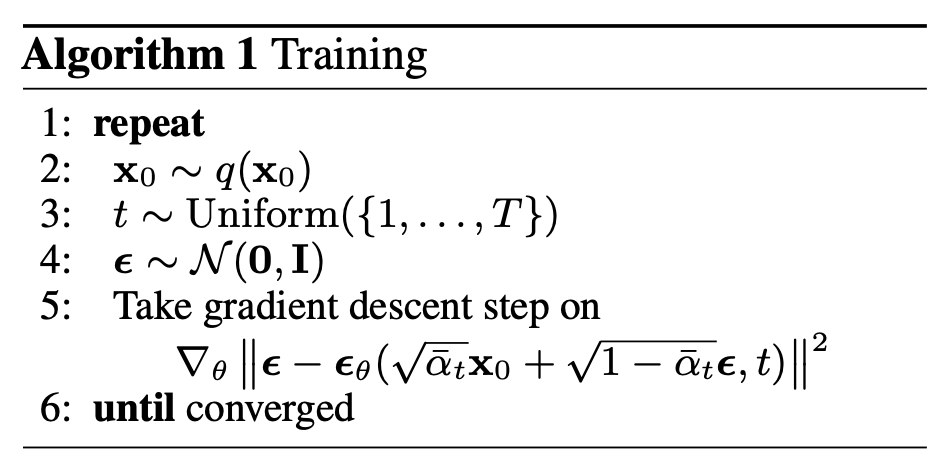


`DiffusionTrainer`: (1.5 pts)
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [11]:
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor, classes: torch.Tensor) -> torch.Tensor:

        t = self.dynamic.sample_time_on_device(x_0.shape[0], self.device)

        batch = self.dynamic.forward({'x_0': x_0, 'time': t})
        eps = batch['eps']
        x_t = batch['x_t']

        eps_theta = self.ddpm(x_t, t, classes)

        loss = torch.nn.functional.mse_loss(eps.to(device), eps_theta.to(device))

        return loss


    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
        ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)
            classes = batch['targets']

            loss = self.calc_loss(x_0=batch['images'], classes=classes)
            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)

            if iter_idx % 2000 == 0:
                self.snapshot()#classes=classes)

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False,
            classes = None,
            guidance_strength = None
    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device,
                                     verbose, classes,
                                     guidance_strength)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self, classes=None) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100, classes=classes).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [12]:
#from denoising_diffusion_pytorch import Unet
from denoising_diffusion_pytorch.classifier_free_guidance import Unet

set_global_seed(42)
ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    cond_drop_prob=0.1,
    num_classes=10
)

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [14]:
generator = get_train_images_generator(128)

In [ ]:
trainer.train(
    generator,
    total_iters=10000
)

wandb: Currently logged in as: isaevoleg8 (isaevoleg8-higher-school-of-economics). Use `wandb login --relogin` to force relogin


  0%|          | 0/10000 [00:00<?, ?it/s]

mse/train,▆█▆▃▄▃▂▃▂▂▃▃▃▂▂▂▃▁▃▃▁▃▁▂▁▃▃▁▂▂▁▁▃▂▁▂▂▂▂▂
mse/train,0.01464


Вы обучили большую модель, самое важное ее сохранить и не потерять!!!

In [ ]:
trainer.switch_to_ema()
torch.save(ddpm.state_dict(), "./pretrained_ddpm_guid_free_checkpoint_10000.pth")

In [ ]:
from IPython.display import FileLink
FileLink(r'pretrained_ddpm_guid_free_checkpoint_10000.pth')

/kaggle/working/pretrained_ddpm_guid_free_checkpoint_10000.pth

#### Безусловная генерация (неплохих картинок - 1 pts)

  0%|          | 0/1000 [00:00<?, ?it/s]

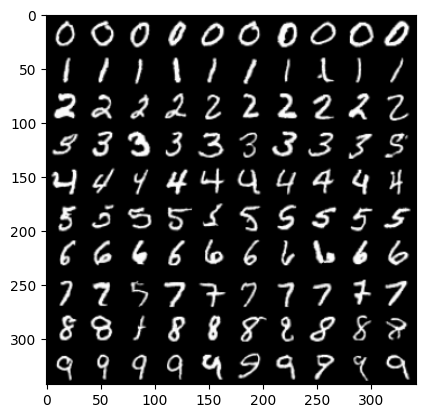

In [ ]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True,
    classes = None,
    guidance_strength = 0.9
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True,
                           classes=classes,
                           guidance_strength=guidance_strength)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

wanted_labels = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)
grid = sample_images(trainer.sampler, 100, trainer.device,
                     guidance_strength=0.9, classes=wanted_labels)

plt.imshow(grid)

  0%|          | 0/1000 [00:00<?, ?it/s]

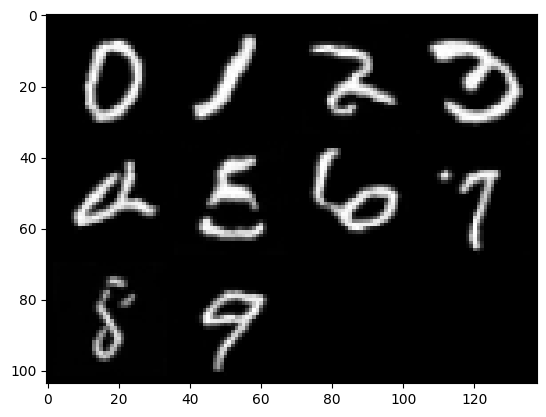

In [ ]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 10,
    device = torch.device('cpu'),
    verbose: bool = True,
    classes = None,
    guidance_strength = 0.9
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True,
                           classes=classes,
                           guidance_strength=guidance_strength)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

wanted_labels = torch.tensor([i for i in range(10)]).flatten().to(device)
grid = sample_images(trainer.sampler, 10, trainer.device,
                     guidance_strength=0.9, classes=wanted_labels)

plt.imshow(grid)

  0%|          | 0/1000 [00:00<?, ?it/s]

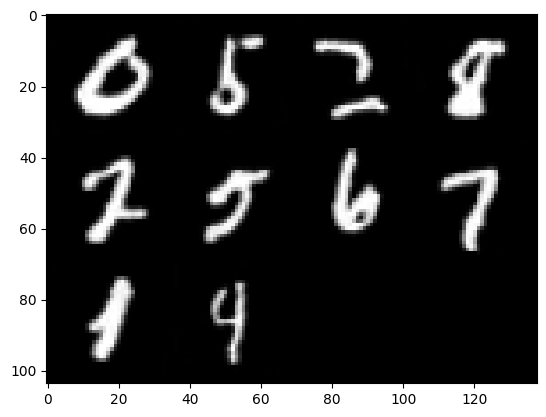

In [ ]:
wanted_labels = torch.tensor([i for i in range(10)]).flatten().to(device)
grid = sample_images(trainer.sampler, 10, trainer.device,
                     guidance_strength=0.5, classes=wanted_labels)

plt.imshow(grid)

In [ ]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True,
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Опишите ваши выводы/результаты: (1 pts)
-
-
-

# Оценка качества (2 pts)

Для оценки качества часто используют метрику FID (Freche Inception Distance), чем ниже FID между двумя наборами изображений, тем более они похожи. На практике мерят FID между выборками одинакового размера, а в качестве эталонной выборки используют обучающую. Вам необходимо посчитать FID для 200, 1_000, 5_000, 8_000 и 10_000 изображений.

Эталоном считается FID посчитанный на выборках размера 50_000 изображений, но это слишком долго в рамках учебной задачи.

Идейно FID равен расстоянию Фреше (расстоянию между двумя нормальными распределениями) в латентном пространстве хорошего классификатора (Inception V3).

Для подсчета метрики, можно использовать [библиотечную реализацию](https://github.com/mseitzer/pytorch-fid)

**Подсказка**

Вы можете сразу сгенерировать 10_000 изображений, а потом аккуратно брать нужное количество для экономии времени.


In [15]:
!pip install pytorch-fid

In [16]:
import os
import PIL

from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
cp /content/drive/MyDrive/Вшэ/байесы/pretrained_ddpm_guid_free_checkpoint_10000.pth ./

In [ ]:
set_global_seed(42)

# ddpm = Unet(
#     dim=64,
#     dim_mults=(1, 2, 4, 4),
#     channels=1,
#     flash_attn=True
# )

In [19]:
checkpoint = torch.load("pretrained_ddpm_guid_free_checkpoint_10000.pth")

ddpm.load_state_dict(checkpoint)
ddpm.eval()

<ipython-input-19-492e10f59ca8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_ddpm_guid_free_checkpoint_10000.pth")


Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (classes_emb): Embedding(10, 64)
  (classes_mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [20]:
device = torch.device('cuda:0')

In [21]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [22]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler, folder: str = '',
    device = torch.device('cuda:0'),
    count: int = 10_00, batch_size: int = 100, seed: int = 42
):

    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)

    for _ in tqdm(range(iter_num)):

        already_sampled = len(os.listdir(folder))
        bs = min(batch_size, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i

            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

In [23]:
def extract_dataset(folder: str, count: int = 10_00):

    os.makedirs(folder, exist_ok=True)
    data = MnistDataset()

    for i in tqdm(range(count)):
        img = data[i]['images']
        img = postprocess_image(img)
        img = img.cpu().permute(1, 2, 0).numpy().astype('uint8')

        file_name = os.path.join(folder, f'img_{i:05d}.png')
        PIL.Image.fromarray(img[:, :, 0], 'L').save(file_name)

In [24]:
extract_dataset("./mnist_data_img")

100%|██████████| 1000/1000 [00:00<00:00, 1662.94it/s]


In [25]:
# Долгая функция

gen_imgs(trainer.sampler, "./mnist_gen_img")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:26<30:59, 206.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 2/10 [06:53<27:32, 206.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 3/10 [10:19<24:04, 206.41s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 4/10 [13:45<20:38, 206.39s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 5/10 [17:12<17:12, 206.42s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 6/10 [20:39<13:46, 206.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 7/10 [24:05<10:19, 206.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 8/10 [27:32<06:53, 206.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [30:58<03:26, 206.34s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 10/10 [34:24<00:00, 206.42s/it]


In [26]:
path_dataset = "./mnist_data_img"
path_output  = "./mnist_gen_img"


fid = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 356MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Нарисуйте график значения FID в зависимости от размера выборок. Учтите, что для корректной работы выборки должны быть одинакового размера. Какие выводы вы можете сделать?

In [29]:
fid_05 = fid.copy()

fid_05

14.510631704402954

In [33]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler, folder: str = '',
    device = torch.device('cuda:0'),
    count: int = 10_00, batch_size: int = 100, seed: int = 42,
    classes = None,
    guidance_strength = 0.9
):

    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)

    for _ in tqdm(range(iter_num)):

        already_sampled = len(os.listdir(folder))
        bs = min(batch_size, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True,
                                classes=classes,
                                guidance_strength=guidance_strength)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i

            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

classes = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)
gen_imgs(trainer.sampler, "./mnist_gen_img_01",
         guidance_strength=0.1,
         classes=classes)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:26<30:56, 206.32s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 2/10 [06:52<27:31, 206.40s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 3/10 [10:18<24:03, 206.19s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 4/10 [13:44<20:36, 206.16s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 5/10 [17:11<17:11, 206.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 6/10 [20:37<13:44, 206.17s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 7/10 [24:03<10:18, 206.16s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 8/10 [27:29<06:52, 206.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [30:56<03:26, 206.48s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 10/10 [34:22<00:00, 206.27s/it]


In [34]:
path_dataset = "./mnist_data_img"
path_output  = "./mnist_gen_img_01"


fid_01 = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


In [35]:
fid_01

15.252017079696088

In [ ]:
classes = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)
gen_imgs(trainer.sampler, "./mnist_gen_img_09",
         guidance_strength=0.9,
         classes=classes)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:21<30:15, 201.77s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 2/10 [06:48<27:15, 204.40s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

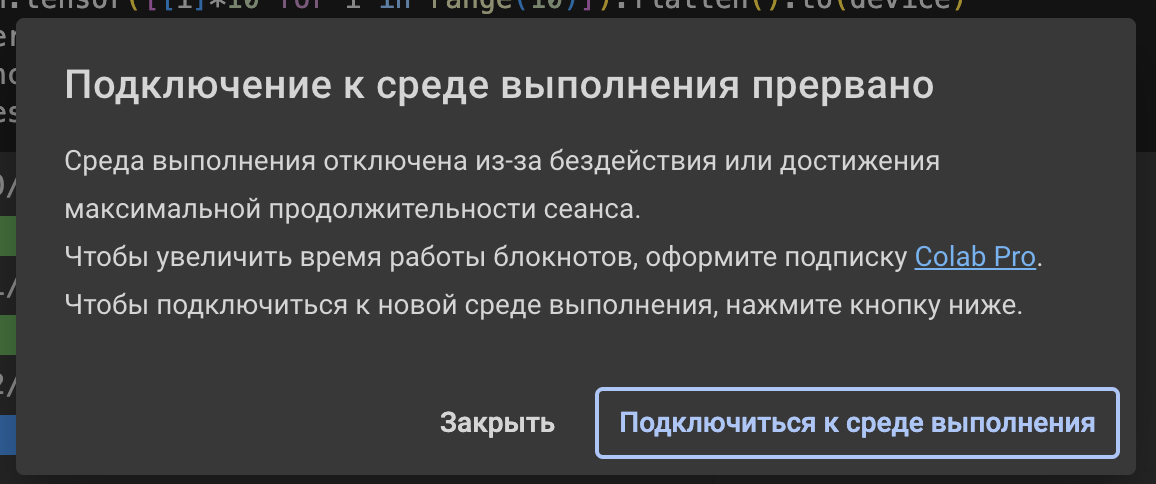

In [ ]:
gen_imgs(trainer.sampler, "./mnist_gen_img_09", guidance_strength=0.9,
         classes=classes)

In [ ]:
!zip -r gen_img.zip mnist_gen_img

In [ ]:
from IPython.display import FileLin
FileLink(r'gen_img.zip')